Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')
    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, _children=(self,), _op='**')
    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    #out = Value(math.tanh(self.data), _children=(self,), _op='tanh')
    t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
    out = Value(t, _children=(self,), _op='tanh')
    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out
    
  def exp(self): # ex.6
    out = Value(math.exp(self.data), _children=(self,), _op='exp')
    def _backward():
      self.grad += math.exp(self.data) * out.grad
    out._backward = _backward
    return out
    
  def relu(self): 
    out = Value(max(0, self.data), _children=(self,), _op='relu')
    def _backward():
      self.grad += (self.data > 0) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


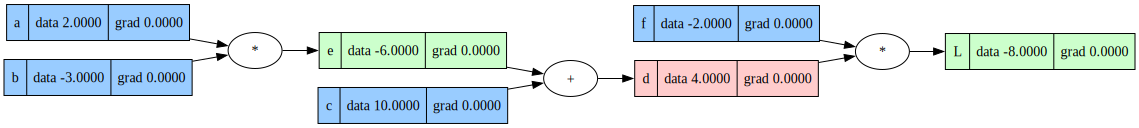

In [6]:
draw_dot(lol())

In [13]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db; with finite differences method.
def lol_grad():
    h = 0.0001
    
    # Calcul de L initial
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    gradients = {}

    # dL/df
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    f += h
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/df"] = (L2 - L1) / h

    # dL/dd
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/dd"] = (L2 - L1) / h

    # dL/de
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e += h
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/de"] = (L2 - L1) / h

    # dL/dc
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/dc"] = (L2 - L1) / h

    # dL/da
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    a += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/da"] = (L2 - L1) / h

    # dL/db
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    b += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    gradients["dL/db"] = (L2 - L1) / h

    print(gradients)

In [15]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# dL/dd = -2.0
# dL/de = -2.0
# dL/dc = -2.0
# dL/da = 6.0
# dL/db = -4.0
lol_grad()


{'dL/df': 3.9999999999995595, 'dL/dd': -1.9999999999953388, 'dL/de': -1.9999999999953388, 'dL/dc': -1.9999999999953388, 'dL/da': 6.000000000021544, 'dL/db': -4.000000000008441}


In [16]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



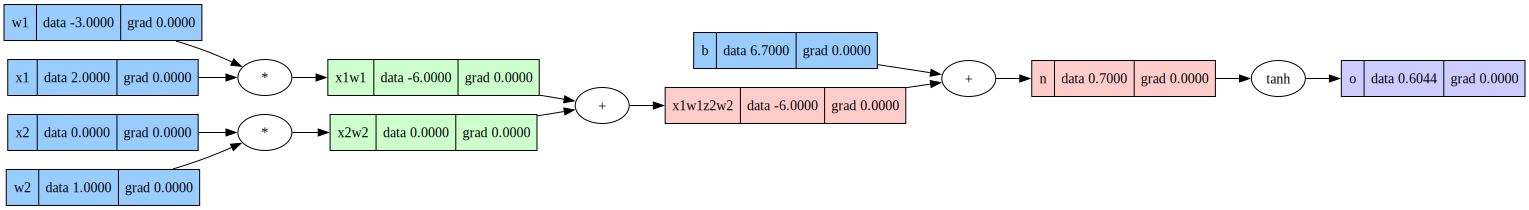

In [17]:
# o.data should be 0.6044
draw_dot(o)

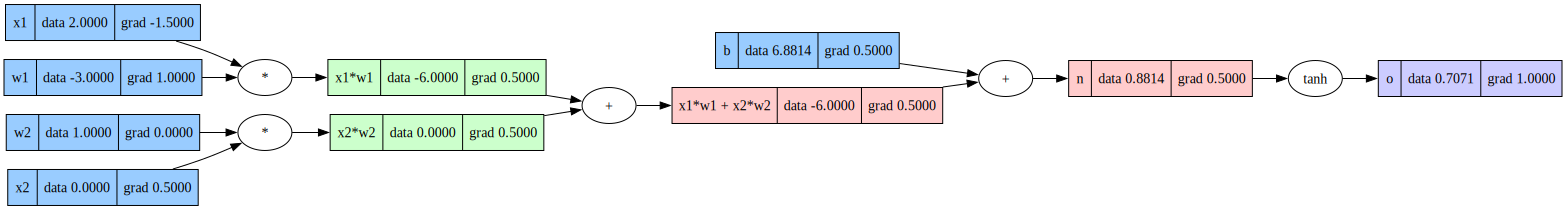

In [18]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

In [ ]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?
# L'utilisation de self.grad += permet d'accumuler correctement les gradients lorsqu'une même variable influence le calcul via plusieurs chemins.
# Si on utilisait self.grad =, on écraserait le gradient précédent à chaque fois.

In [23]:
a = Value(1.0)
b = a + a
b.backward()
print("gradient de a :", a.grad)
print("gradient de b = a + a :", b.grad)

gradient de a : 2.0
gradient de b = a + a : 1.0


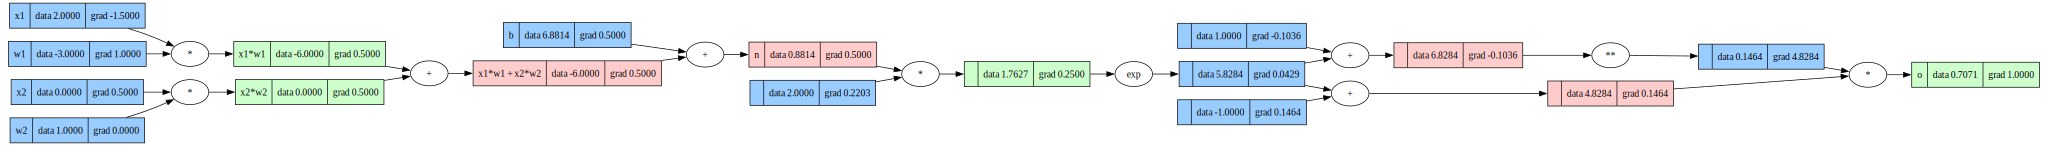

In [20]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [24]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [ ]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [36]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] 
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]   # on applique chaque neurone de la couche à l'entrée x
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]  # on récupère les paramètres de chaque neurone de la couche (w et b)

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)  # on applique chaque couche à l'entrée x
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]  # on récupère les paramètres de chaque couche

In [37]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.655962813509458)

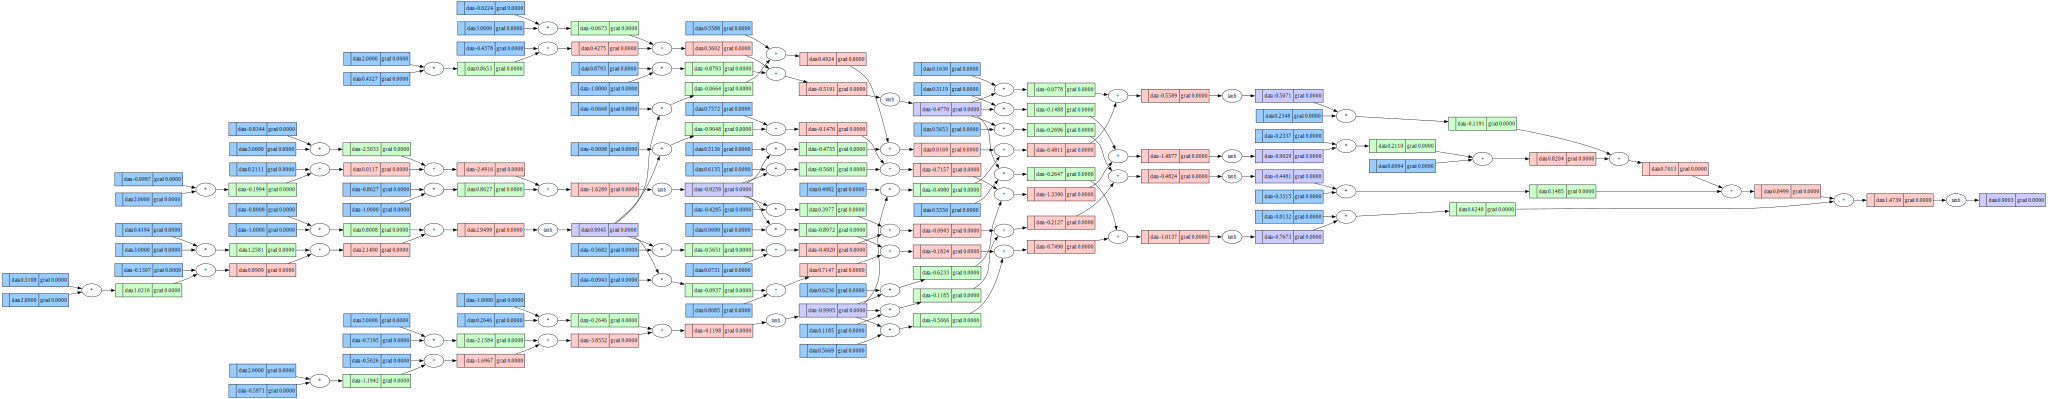

In [57]:
draw_dot(n(x))

In [58]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [59]:
len(n.parameters())

41

In [60]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.90031805154669),
 Value(data=0.013547016563790381),
 Value(data=0.45677392085864277),
 Value(data=0.7978012716688276)]

In [61]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=3.2002886278654152)

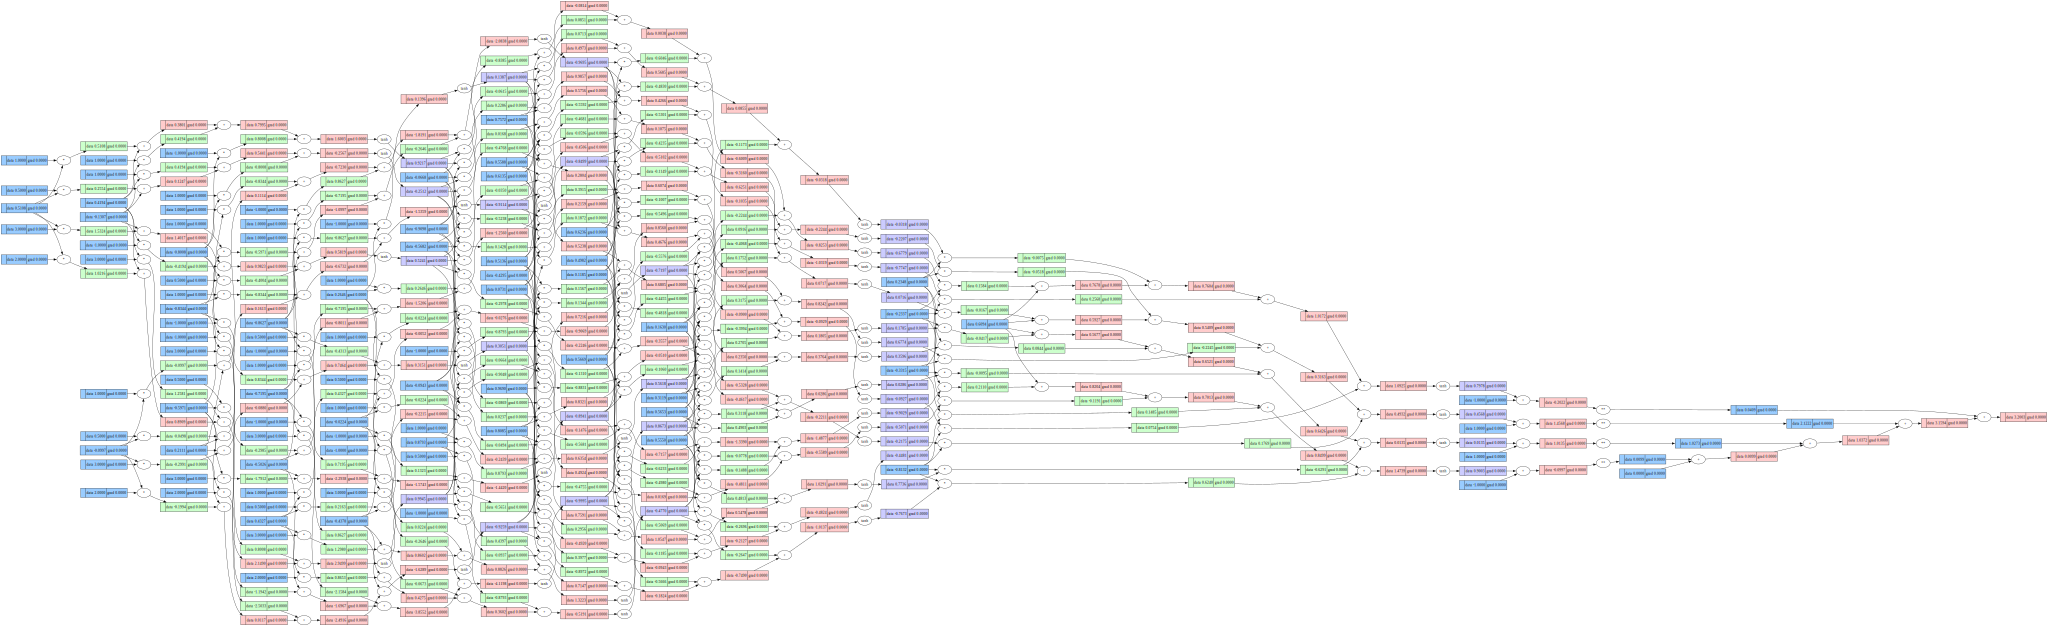

In [62]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [ ]:
# Exercise 8: write a training loop
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)]) # MSE between ypred and ground-truth
    #backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data -= 0.01 * p.grad
    print(k, loss.data)

0 3.2002886278654152
1 2.632333167292688
2 2.1035542986473015
3 1.6468061243631043
4 1.2856120806538895
5 1.018713301127598
6 0.8272097283133866
7 0.6892620488793889
8 0.58763217951145
9 0.5105651620656977
10 0.45043227706676636
11 0.40230336117900417
12 0.3629383185161799
13 0.3301524293900578
14 0.30243019722190456
15 0.27869056449599566
16 0.2581420775319123
17 0.24019159079447214
18 0.22438528823597775
19 0.2103696056253239


In [ ]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.
# On a besoin de réinitialiser les gradients à zéro à chaque étape d'entraînement car on veut calculer les gradients de la loss par rapport à chaque paramètre du réseau individuellement et si on ne les réinitialise pas, les gradients s'accumule à chaque itération.

In [39]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  Why is it so hard?
# Génération des données (entrées et sorties)
xs = [[Value(x)] for x in np.arange(-2, 2.1, 0.1)]  # Entrées (n)
ys = [Value(x[0].data ** 2) for x in xs]   # Sorties (n^2)

# Création du MLP avec 2 couches cachées
mlp = MLP(1, [10, 10, 1])  # 1 entrée, 10 neurones, 10 neurones, 1 sortie

# Boucle d'entraînement
for k in range(100):
    # Forward pass (prédictions)
    ypred = [mlp(x) for x in xs]
    
    # Calcul de la perte (Mean Squared Error)
    loss = sum([(yp - y) ** 2 for yp, y in zip(ypred, ys)])

    # Backward pass (reset gradients et propagation)
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # Mise à jour des poids (descente de gradient)
    lr = 0.001
    for p in mlp.parameters():
        p.data -= lr * p.grad

    # Affichage de la perte toutes les 10 itérations
    if k % 10 == 0:
        print(f"Iteration {k}, Loss: {loss.data:.4f}")

Iteration 0, Loss: 207.5718
Iteration 10, Loss: 75.6817
Iteration 20, Loss: 71.9251
Iteration 30, Loss: 70.4455
Iteration 40, Loss: 68.4167
Iteration 50, Loss: 65.7843
Iteration 60, Loss: 64.1550
Iteration 70, Loss: 63.2245
Iteration 80, Loss: 62.6560
Iteration 90, Loss: 62.2863


In [ ]:
# La loss diminue bien à chaque itération, bien qu'elle reste élevée à la fin des 100 itérations.

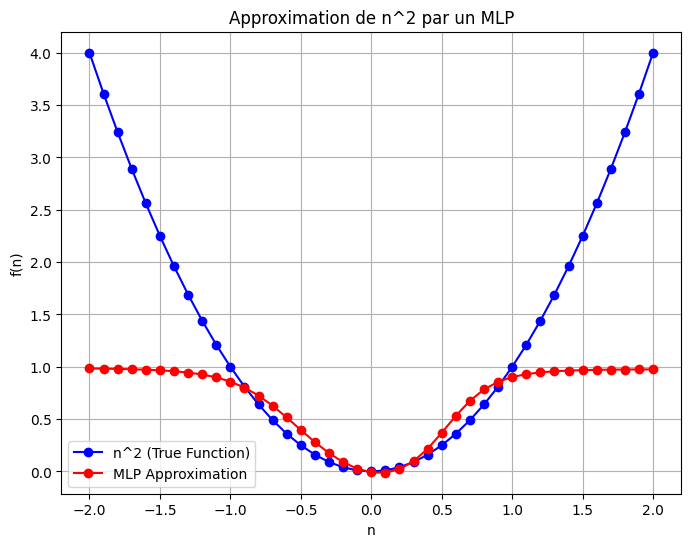

In [40]:
# Affichage des résultats
x_vals = [x[0].data for x in xs]
y_true = [y.data for y in ys]             # Valeurs réelles (n^2)
y_pred = [mlp([Value(x)]).data for x in x_vals]  # Valeurs prédites par le MLP

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_true, 'bo-', label="n^2 (True Function)")  # Courbe bleue
plt.plot(x_vals, y_pred, 'ro-', label="MLP Approximation")    # Courbe rouge
plt.xlabel("n")
plt.ylabel("f(n)")
plt.title("Approximation de n^2 par un MLP")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# On peut voir que l'approximation de n^2 par un 2-layer MLP est plutôt correcte sur la plage [-1, 1], mais dès qu'on s'éloigne de cette plage, l'approximation devient très mauvaise.
# Cela s'explique notamment par le fait que la fonction d'activation tanh est bornée entre -1 et 1, ce qui rend difficile l'approximation de fonctions non bornées comme n^2. 
# Pour approximer n^2, il faudrait utiliser une fonction d'activation non bornée.

In [ ]:
# Test avec ReLU
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
    out = act.relu()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] 
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]   # on applique chaque neurone de la couche à l'entrée x
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]  # on récupère les paramètres de chaque neurone de la couche (w et b)

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)  # on applique chaque couche à l'entrée x
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]  # on récupère les paramètres de chaque couche

In [42]:
# Génération des données (entrées et sorties)
xs = [[Value(x)] for x in np.arange(-2, 2.1, 0.1)]  # Entrées (n)
ys = [Value(x[0].data ** 2) for x in xs]   # Sorties (n^2)

# Création du MLP avec 2 couches cachées
mlp = MLP(1, [10, 10, 1])  # 1 entrée, 10 neurones, 10 neurones, 1 sortie

# Boucle d'entraînement
for k in range(100):
    # Forward pass (prédictions)
    ypred = [mlp(x) for x in xs]
    
    # Calcul de la perte (Mean Squared Error)
    loss = sum([(yp - y) ** 2 for yp, y in zip(ypred, ys)])

    # Backward pass (reset gradients et propagation)
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # Mise à jour des poids (descente de gradient)
    lr = 0.001
    for p in mlp.parameters():
        p.data -= lr * p.grad

    # Affichage de la perte toutes les 10 itérations
    if k % 10 == 0:
        print(f"Iteration {k}, Loss: {loss.data:.4f}")

Iteration 0, Loss: 29.7863
Iteration 10, Loss: 10.5011
Iteration 20, Loss: 3.0772
Iteration 30, Loss: 1.1757
Iteration 40, Loss: 0.7902
Iteration 50, Loss: 0.6814
Iteration 60, Loss: 0.6241
Iteration 70, Loss: 0.5846
Iteration 80, Loss: 0.5525
Iteration 90, Loss: 0.5248


In [ ]:
# La loss diminue bien à chaque itération et est bien plus faible qu'avec la fonction tanh.

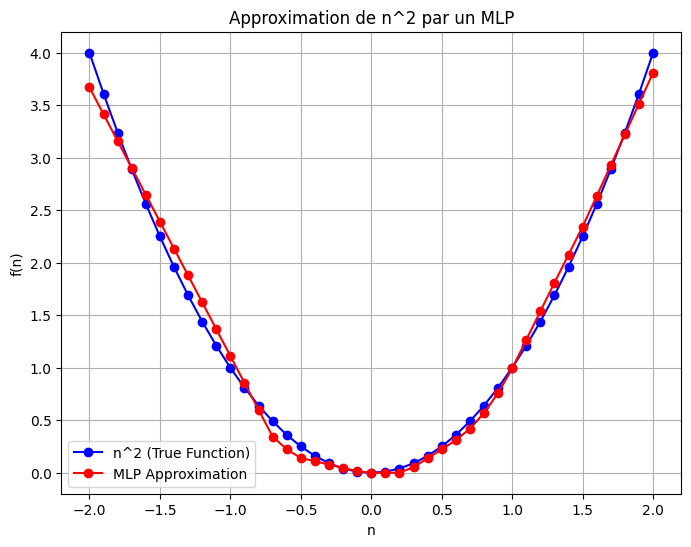

In [43]:
# Affichage des résultats
x_vals = [x[0].data for x in xs]
y_true = [y.data for y in ys]             # Valeurs réelles (n^2)
y_pred = [mlp([Value(x)]).data for x in x_vals]  # Valeurs prédites par le MLP

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_true, 'bo-', label="n^2 (True Function)")  # Courbe bleue
plt.plot(x_vals, y_pred, 'ro-', label="MLP Approximation")    # Courbe rouge
plt.xlabel("n")
plt.ylabel("f(n)")
plt.title("Approximation de n^2 par un MLP")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# L'approximation de la fonction n^2 est bien meilleure que précédemment et ce sur toute la plage [-2, 2] avec un 2-layer MLP et une fonction d'activation ReLU.
# Cela montre l'importance du choix de la fonction d'activation pour l'approximation de fonctions spécifiques.